In [162]:

import pandas as pd
tsvfile = 'soc-redditHyperlinks-body.tsv'
# tsvfile = 'soc-redditHyperlinks-title.tsv'

df = pd.read_csv(tsvfile, delimiter='\t')
print(df[:5])
print(df.columns)



  SOURCE_SUBREDDIT TARGET_SUBREDDIT  POST_ID            TIMESTAMP  \
0  leagueoflegends  teamredditteams  1u4nrps  2013-12-31 16:39:58   
1       theredlion           soccer   1u4qkd  2013-12-31 18:18:37   
2     inlandempire           bikela  1u4qlzs  2014-01-01 14:54:35   
3              nfl              cfb  1u4sjvs  2013-12-31 17:37:55   
4       playmygame          gamedev  1u4w5ss  2014-01-01 02:51:13   

   LINK_SENTIMENT                                         PROPERTIES  
0               1  345.0,298.0,0.75652173913,0.0173913043478,0.08...  
1              -1  101.0,98.0,0.742574257426,0.019801980198,0.049...  
2               1  85.0,85.0,0.752941176471,0.0235294117647,0.082...  
3               1  1124.0,949.0,0.772241992883,0.0017793594306,0....  
4               1  715.0,622.0,0.777622377622,0.00699300699301,0....  
Index(['SOURCE_SUBREDDIT', 'TARGET_SUBREDDIT', 'POST_ID', 'TIMESTAMP',
       'LINK_SENTIMENT', 'PROPERTIES'],
      dtype='object')


In [163]:
# choose the 2014 data
df_2014 = df[df['TIMESTAMP'].str.contains("2014")]

df_2014['TIMESTAMP'] = pd.to_datetime(df_2014['TIMESTAMP'])
quarters = {
    'Q1': ('2014-01-01', '2014-03-31'),
    'Q2': ('2014-04-01', '2014-06-30'),
    'Q3': ('2014-07-01', '2014-09-30'),
    'Q4': ('2014-10-01', '2014-12-31'),
}

# Create a dictionary to hold the DataFrames for each quarter
quarter_dfs = {}

# Split the DataFrame into quarters
for quarter, (start_date, end_date) in quarters.items():
    start = pd.to_datetime(start_date)
    end = pd.to_datetime(end_date)
    quarter_dfs[quarter] = df_2014[(df_2014['TIMESTAMP'] >= start) & (df_2014['TIMESTAMP'] <= end)]


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [164]:
import networkx as nx
# Function to create a MultiDiGraph from a DataFrame
def create_multidigraph(df):
    G = nx.MultiDiGraph()
    # print(df)
    for _, row in df.iterrows():
        source = row['SOURCE_SUBREDDIT']
        target = row['TARGET_SUBREDDIT']
        sentiment = row['LINK_SENTIMENT']
        property = row['PROPERTIES'].split(",")
        # print(property[48], property[49])
        sentiment = float(property[48]) - float(property[49])
        # print(type(property))
        G.add_edge(source, target, weight=sentiment)
    return G

# Function to convert MultiDiGraph to DiGraph and aggregate weights
def convert_and_aggregate(G):
    DG = nx.DiGraph()
    for u, v, data in G.edges(data=True):
        if DG.has_edge(u, v):
            DG[u][v]['weight'] += data['weight']
        else:
            DG.add_edge(u, v, weight=data['weight'])
    return DG

# Function to calculate metrics for a graph
def calculate_metrics(G, DG):
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    avg_clustering = nx.average_clustering(DG)
    
    # Calculate the average weight from the original MultiDiGraph
    total_weight = sum(data['weight'] for _, _, data in G.edges(data=True))
    avg_weight = total_weight / G.number_of_edges() if G.number_of_edges() > 0 else 0
    
    return num_nodes, num_edges, avg_clustering, avg_weight

# Calculate and print metrics for each quarter
for quarter, q_df in quarter_dfs.items():
    G = create_multidigraph(q_df)
    DG = convert_and_aggregate(G)
    num_nodes, num_edges, avg_clustering, avg_weight = calculate_metrics(G, DG)
    print(f"Metrics for {quarter}:")
    print(f"  Number of nodes: {num_nodes}")
    print(f"  Number of edges: {num_edges}")
    print(f"  Average clustering coefficient: {avg_clustering}")
    print(f"  Average weight of edges: {avg_weight*100}")
    print()

Metrics for Q1:
  Number of nodes: 4969
  Number of edges: 14049
  Average clustering coefficient: 0.0645856963903135
  Average weight of edges: 1.5577291643807314

Metrics for Q2:
  Number of nodes: 5520
  Number of edges: 15150
  Average clustering coefficient: 0.06310539948562541
  Average weight of edges: 1.594322563291584

Metrics for Q3:
  Number of nodes: 5972
  Number of edges: 16529
  Average clustering coefficient: 0.061494465452295484
  Average weight of edges: 1.5752290714876684

Metrics for Q4:
  Number of nodes: 6233
  Number of edges: 16832
  Average clustering coefficient: 0.05823004982279057
  Average weight of edges: 1.6557493584482645



more nodes and more edges indicates more and more posts start referencing throughout the year.
the average clustering coefficient is quite small, this indicates that the network does not have strong local community structure.
averge weight of edges is neutral.

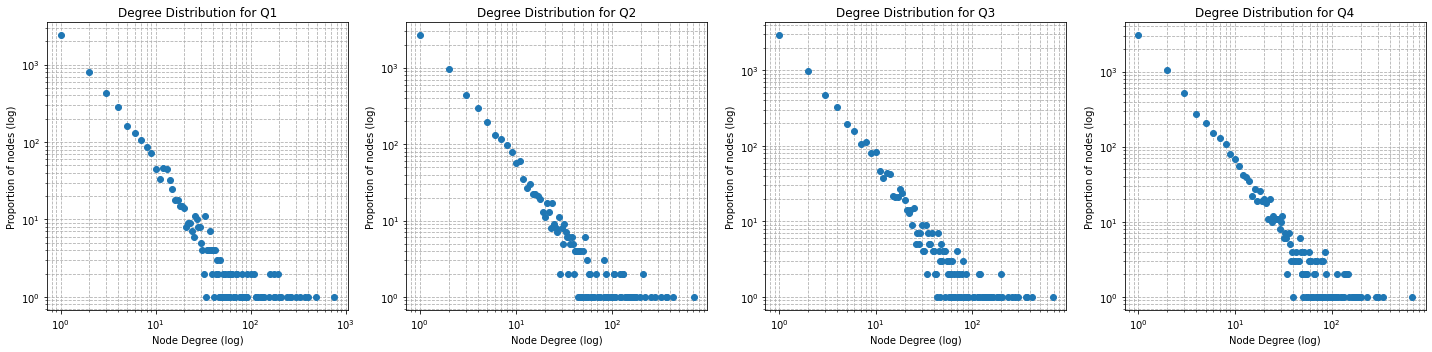

In [165]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Function to plot degree distribution on a log-log scale in a given subplot
def plot_degree_distribution(G, title, ax):
    degree_sequence = [d for n, d in G.degree()]
    
    # Calculate degree counts
    degree_counts = np.bincount(degree_sequence)
    degrees = np.nonzero(degree_counts)[0]
    counts = degree_counts[degrees]
    
    # Plot
    ax.loglog(degrees, counts, marker='o', linestyle='None')
    ax.set_title(f'Degree Distribution for {title}')
    ax.set_xlabel('Node Degree (log)')
    ax.set_ylabel('Proportion of nodes (log)')
    ax.grid(True, which="both", ls="--")

# Number of quarters
num_quarters = len(quarter_dfs)

# Create a figure and an array of subplots with 1 row and num_quarters columns
fig, axs = plt.subplots(1, num_quarters, figsize=(20, 5))

# Iterate through each quarter and plot the degree distribution in each subplot
for i, (quarter, q_df) in enumerate(quarter_dfs.items()):
    G_quarter = create_multidigraph(q_df)
    
    plot_degree_distribution(G_quarter, quarter, axs[i])

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()


We see that the Reddit subreddit hyperlink network follow a power-law distribution because the trend is linear on a log-log plot. There are a large number of subreddits community who refers to posts from other subreddits very infrequently, and there are a small number of subreddits refered to as "power subreddits" who refers to posts from other subreddits far more frequently. This also suggests that if emotion can flow through this network, those "power subreddits" will have a huge influence over the flow of emotion to the rest of the network.

Correlation coefficient for Q1 2014: 0.13681459626510684
Correlation coefficient for Q2 2014: 0.17736056443632764
Correlation coefficient for Q3 2014: 0.22470072400821242
Correlation coefficient for Q4 2014: 0.22268108864190486


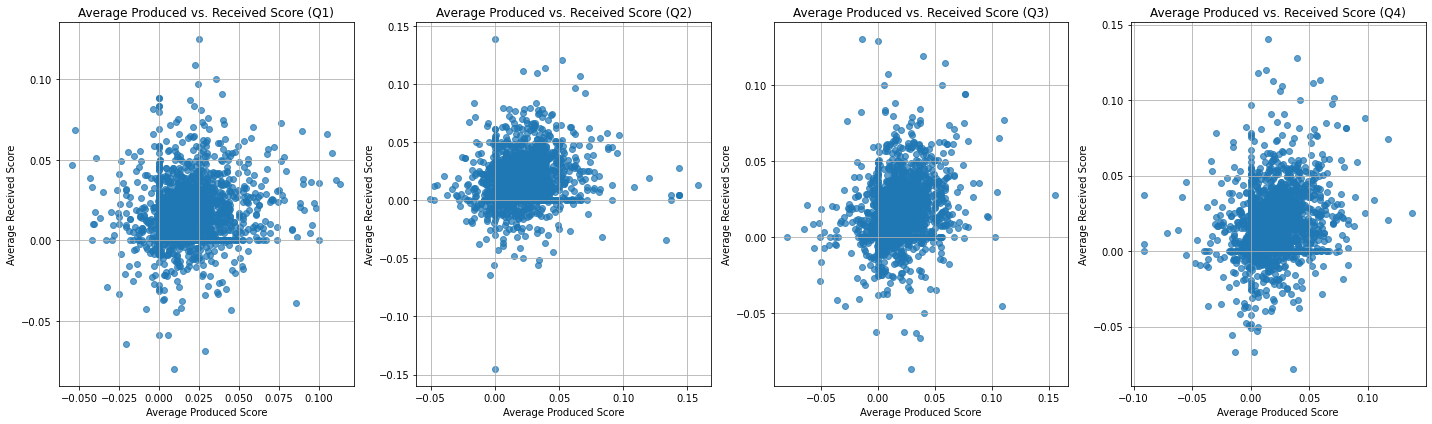

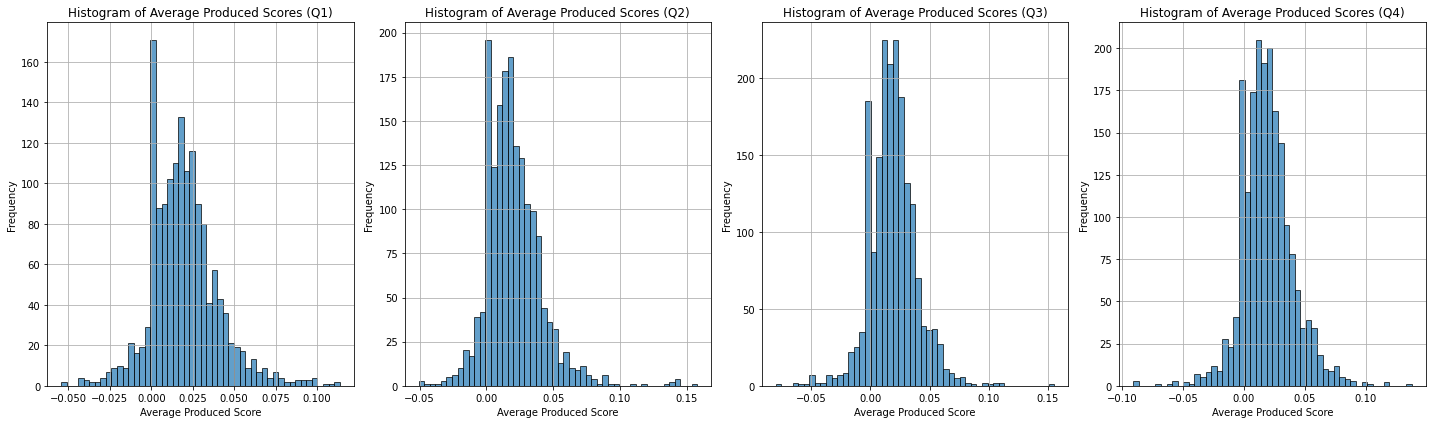

In [166]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

def calculate_scores(G):
    """Calculate average produced and received scores for each node in the graph."""
    produced_scores = {}
    received_scores = {}

    for node in G.nodes():
        out_edges = G.out_edges(node, data=True)
        in_edges = G.in_edges(node, data=True)
        if out_edges:
            produced_scores[node] = sum(data['weight'] for _, _, data in out_edges) / len(out_edges)
        if in_edges:
            received_scores[node] = sum(data['weight'] for _, _, data in in_edges) / len(in_edges)
    
    return produced_scores, received_scores

# Function to plot scatter plot of produced vs. received scores in a given subplot
def plot_scatter(ax, produced, received, title):
    """Plot a scatter plot of produced vs. received scores."""
    ax.scatter(produced, received, alpha=0.7)
    ax.set_title(title)
    ax.set_xlabel('Average Produced Score')
    ax.set_ylabel('Average Received Score')
    ax.grid(True)

# Function to plot histogram of average produced scores in a given subplot
def plot_histogram(ax, produced, title):
    """Plot a histogram of average produced scores."""
    ax.hist(produced, bins=50, alpha=0.7, edgecolor='black')
    ax.set_title(title)
    ax.set_xlabel('Average Produced Score')
    ax.set_ylabel('Frequency')
    ax.grid(True)

# Number of quarters
num_quarters = len(quarter_dfs)

# Create a figure with subplots for scatter plots
fig1, axs1 = plt.subplots(1, num_quarters, figsize=(20, 6))

# Create a figure with subplots for histograms
fig2, axs2 = plt.subplots(1, num_quarters, figsize=(20, 6))

# Calculate and plot metrics for each quarter
for i, (quarter, q_df) in enumerate(quarter_dfs.items()):
    G_quarter = create_multidigraph(q_df)
    produced_scores, received_scores = calculate_scores(G_quarter)

    # Prepare data for plotting
    produced = []
    received = []

    for node in G_quarter.nodes():
        if node in produced_scores and node in received_scores:
            produced.append(produced_scores[node])
            received.append(received_scores[node])

    if produced and received:
        correlation_coefficient = np.corrcoef(produced, received)[0, 1]
        print(f'Correlation coefficient for {quarter} 2014: {correlation_coefficient}')

    # Plot the scatter plot for the quarter in the first row
    plot_scatter(axs1[i], produced, received, f'Average Produced vs. Received Score ({quarter})')
    # Plot the histogram for the quarter in the second row
    plot_histogram(axs2[i], produced, f'Histogram of Average Produced Scores ({quarter})')

# Adjust layout to prevent overlap
fig1.tight_layout()
fig2.tight_layout()

# Display the plots
plt.show()


This plots investigate the relationship between average produced score and average received score; do emotionally positive posts towards other subreddits invite more emotionally postive responses?
The plot and the correlation coefficient indicates that there is negligible relationship between the average produced score and average received score. Maybe because most of the posts are neutral?
plot a histogram: x is the average produced score and the y is the frequency. We see that indeed, the most average produced scores are centred around 0. This might indicates that interaction between subreddit is too large that normalised all the emotional 

Neutral Sentiment Dominance: If most posts have neutral sentiment, it suggests that interactions between subreddits tend to be neutral rather than emotionally charged.

Neutral Posts Inviting Neutral Responses:

    If the majority of posts are neutral, it could mean that neutral posts often get neutral responses. This would align with the observed negligible correlation, as there isn't a strong emotional response pattern.
    Neutral sentiment being the dominant sentiment can dilute the impact of positive or negative posts, making the overall relationship appear weaker.

Correlation Coefficient: -0.037093773908696115
p-value: 0.02214611876601042
Correlation Coefficient: 0.005524384912301564
p-value: 0.7430388336878633
Correlation Coefficient: 0.045937535391255925
p-value: 0.011716285367341178


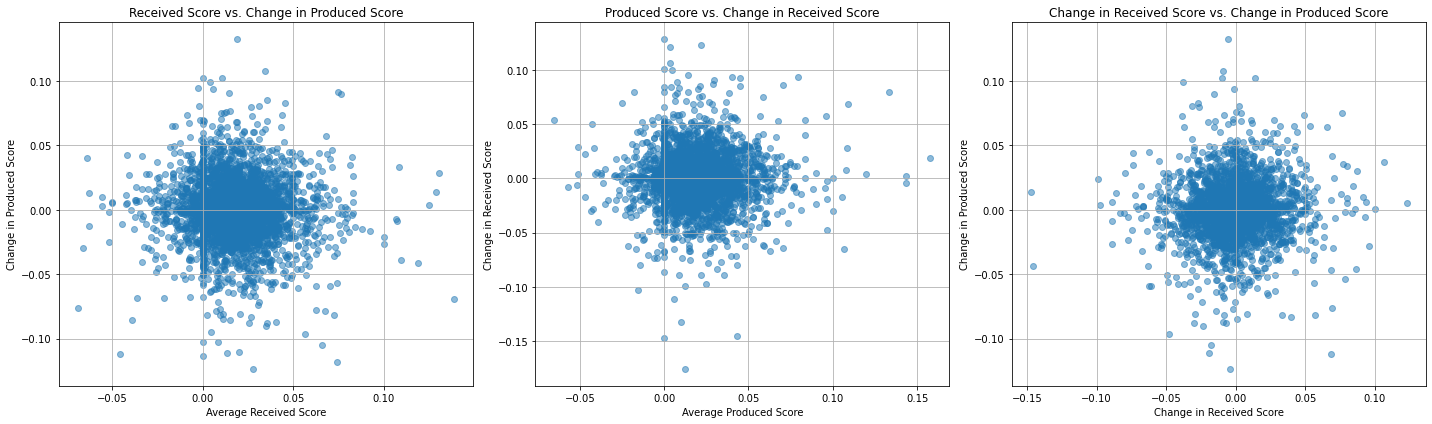

In [167]:
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

# Initialize lists to store data for plotting
x_values = []
y_values = []

# Create subplots for all three scatter plots
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

# plot 1: subreddit's received score on x, subreddit change in produced score from one quarter to the next on y
# Iterate over each pair of consecutive quarters
for i in range(3):
    # Get quarter keys for current and next quarters
    current_quarter = list(quarters.keys())[i]
    next_quarter = list(quarters.keys())[i + 1]

    # Append the scores to the lists
    for subreddit in received_scores_dict[current_quarter].keys():
        if subreddit in produced_scores_dict[current_quarter] and subreddit in produced_scores_dict[next_quarter]:
            x_values.append(received_scores_dict[current_quarter][subreddit])
            y_values.append(produced_scores_dict[next_quarter][subreddit] - produced_scores_dict[current_quarter][subreddit])

# Create scatter plot 1
axs[0].scatter(x_values, y_values, alpha=0.5)
axs[0].set_xlabel('Average Received Score')
axs[0].set_ylabel('Change in Produced Score')
axs[0].set_title('Received Score vs. Change in Produced Score')
axs[0].grid(True)

# Calculate the correlation coefficient and p-value
correlation_coefficient, p_value = pearsonr(x_values, y_values)
print("Correlation Coefficient:", correlation_coefficient)
print("p-value:", p_value)

# Reset lists for next plot
x_values = []
y_values = []

# plot 2: subreddit's produced score on x, subreddit change in received score from one quarter to the next on y
# Iterate over each pair of consecutive quarters
for i in range(3):
    # Get quarter keys for current and next quarters
    current_quarter = list(quarters.keys())[i]
    next_quarter = list(quarters.keys())[i + 1]

    # Append the scores to the lists
    for subreddit in produced_scores_dict[current_quarter].keys():
        if subreddit in received_scores_dict[current_quarter] and subreddit in received_scores_dict[next_quarter]:
            x_values.append(produced_scores_dict[current_quarter][subreddit])
            y_values.append(received_scores_dict[next_quarter][subreddit] - received_scores_dict[current_quarter][subreddit])

# Create scatter plot 2
axs[1].scatter(x_values, y_values, alpha=0.5)
axs[1].set_xlabel('Average Produced Score')
axs[1].set_ylabel('Change in Received Score')
axs[1].set_title('Produced Score vs. Change in Received Score')
axs[1].grid(True)

# Calculate the correlation coefficient and p-value
correlation_coefficient, p_value = pearsonr(x_values, y_values)
print("Correlation Coefficient:", correlation_coefficient)
print("p-value:", p_value)

# Reset lists for next plot
x_values = []
y_values = []

# plot 3: subreddit's change in the received score from one quarter to the next, change in the produced score from one quarter to the next
# Iterate over each pair of consecutive quarters
for i in range(3):
    # Get quarter keys for current and next quarters
    current_quarter = list(quarters.keys())[i]
    next_quarter = list(quarters.keys())[i + 1]

    # Append the change in received and produced scores to the lists
    for subreddit in produced_scores_dict[current_quarter].keys():
        if subreddit in produced_scores_dict[next_quarter] and subreddit in produced_scores_dict[current_quarter] and subreddit in received_scores_dict[next_quarter] and subreddit in received_scores_dict[current_quarter]:
            x_values.append(received_scores_dict[next_quarter][subreddit] - received_scores_dict[current_quarter][subreddit])
            y_values.append(produced_scores_dict[next_quarter][subreddit] - produced_scores_dict[current_quarter][subreddit])

# Create scatter plot 3
axs[2].scatter(x_values, y_values, alpha=0.5)
axs[2].set_xlabel('Change in Received Score')
axs[2].set_ylabel('Change in Produced Score')
axs[2].set_title('Change in Received Score vs. Change in Produced Score')
axs[2].grid(True)

# Calculate the correlation coefficient and p-value
correlation_coefficient, p_value = pearsonr(x_values, y_values)
print("Correlation Coefficient:", correlation_coefficient)
print("p-value:", p_value)

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()



So to answer your question: 𝑟 close to 0 and p-value < 0.05 would mean that there is a correlation, but it is very weak.
The plots above suggest that there is no strong correlation between produced score and received score.

In [168]:
def create_multidigraph(df):
    G = nx.MultiDiGraph()
    # print(df)
    for _, row in df.iterrows():
        source = row['SOURCE_SUBREDDIT']
        target = row['TARGET_SUBREDDIT']
        sentiment = row['LINK_SENTIMENT']
        property = row['PROPERTIES'].split(",")
        # print(property[48], property[49])
        sentiment = float(property[48]) - float(property[49])
        # print(type(property))
        G.add_edge(source, target, weight=sentiment)
    return G
def create_samples():
    data = []
    for i in range(len(quarters) - 1):
        current_quarter = list(quarters.keys())[i]
        next_quarter = list(quarters.keys())[i + 1]
        # print(quarter_dfs[current_quarter])
        G_current = create_multidigraph(quarter_dfs[current_quarter])
        G_next = create_multidigraph(quarter_dfs[next_quarter])
        current_produced_scores, current_received_scores = calculate_scores(G_current)
        next_produced_scores, next_received_scores = calculate_scores(G_next)
        
        for subreddit in current_produced_scores:
            if subreddit in next_produced_scores and subreddit in current_received_scores and subreddit in next_received_scores and subreddit in current_produced_scores:
                degree = G_current.degree(subreddit)
                total_received = current_received_scores[subreddit]
                avg_received = total_received / degree if degree != 0 else 0
                change_in_avg_produced = next_produced_scores[subreddit] - current_produced_scores[subreddit]
                change_in_avg_received = abs(next_received_scores[subreddit] - current_received_scores[subreddit])
                target = 1 if abs(change_in_avg_produced) > 0.01 else 0
                data.append([degree, total_received, avg_received, change_in_avg_received, target])
    return pd.DataFrame(data, columns=['degree', 'total_received_emotional_score', 'average_received_emotional_score', 'change in avg received', 'target'])

# Create samples
samples_df = create_samples()

from sklearn.preprocessing import StandardScaler

# Features and target
X = samples_df[['degree', 'total_received_emotional_score', 'average_received_emotional_score', 'change in avg received']]
y = samples_df['target']

# Normalize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)


Model: Random Forest (10 Trees)
Accuracy: 0.541860465116279
Precision: 0.5713328868050904
Recall: 0.5358040201005025
F1 Score: 0.552998379254457
AUROC: 0.5662254325222729
Model: Logistic Regression
Accuracy: 0.6152823920265781
Precision: 0.5979241877256317
Recall: 0.832286432160804
F1 Score: 0.6959033613445378
AUROC: 0.6426851730443472
Model: K-Nearest Neighbors
Accuracy: 0.5604651162790698
Precision: 0.5815645845967253
Recall: 0.6023869346733668
F1 Score: 0.5917926565874729
AUROC: 0.5773751514979694


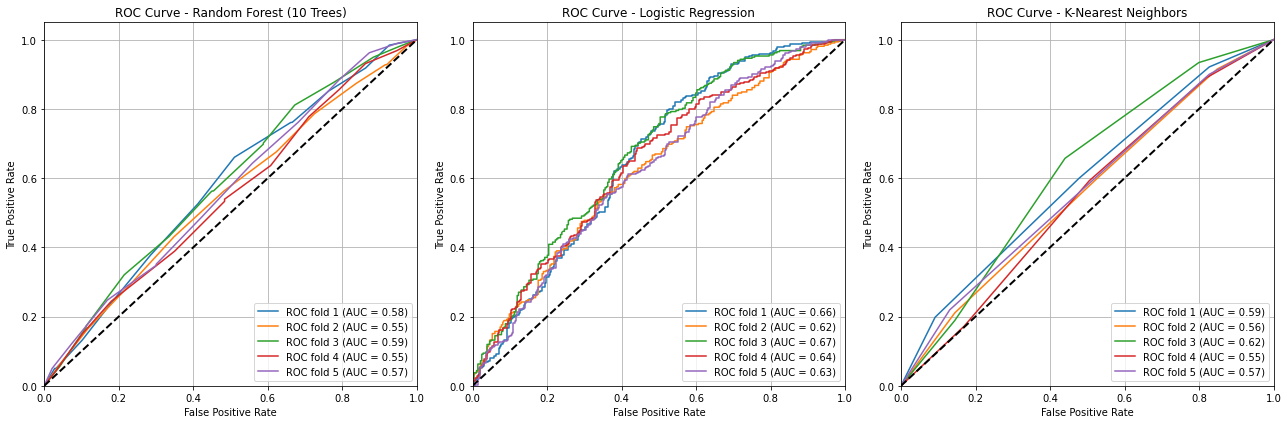

In [169]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc

# Set random seed for reproducibility
random_seed = 42
np.random.seed(random_seed)

# Function to evaluate the model
def evaluate_model(X, y, model, model_name, ax):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed)
    y_pred = np.zeros(y.shape)
    y_prob = np.zeros(y.shape)
    
    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        model.fit(X_train, y_train)
        
        y_pred[test_index] = model.predict(X_test)
        y_prob[test_index] = model.predict_proba(X_test)[:, 1]
        
        fpr, tpr, _ = roc_curve(y_test, y_prob[test_index])
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, label=f'ROC fold {i+1} (AUC = {roc_auc:.2f})')
    
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    auroc = roc_auc_score(y, y_prob)

    # Print the metrics
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"AUROC: {auroc}")
    
    ax.plot([0, 1], [0, 1], 'k--', lw=2)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve - {model_name}')
    ax.legend(loc="lower right")
    ax.grid()

# Initialize subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Evaluate the Random Forest model
rf_model = RandomForestClassifier(n_estimators=10, random_state=random_seed)
evaluate_model(X, y, rf_model, "Random Forest (10 Trees)", axes[0])

# Evaluate the Logistic Regression model
lr_model = LogisticRegression(random_state=random_seed)
evaluate_model(X, y, lr_model, "Logistic Regression", axes[1])

# Evaluate the K-Nearest Neighbors model
knn = KNeighborsClassifier(n_neighbors=3)
evaluate_model(X, y, knn, "K-Nearest Neighbors", axes[2])

# Adjust layout
plt.tight_layout()
plt.show()


The mean cross-validation score of approximately 0.511 indicates that the KNN model performs slightly better than random guessing, which would yield an expected accuracy of 50% in a binary classification problem. However, this marginal improvement over the baseline is not substantial.
Conclusion

The model's performance, with an average accuracy only slightly above 50%, suggests that the predictive power of the KNN classifier with the current feature set is weak. This result indicates that the model is not particularly effective at predicting changes in the emotional tone of subreddits based on the given features.